# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 

## Подготовка данных

In [2]:
try: # чтение файлов с сайта
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except: # чтение файлов локально
    contract = pd.read_csv('C:\\Users\dedal\OneDrive\Рабочий стол\Яндекс.Практикум\Диплом\\final_provider\\final_provider\contract.csv')
    internet = pd.read_csv('C:\\Users\dedal\OneDrive\Рабочий стол\Яндекс.Практикум\Диплом\\final_provider\\final_provider\internet.csv')
    personal = pd.read_csv('C:\\Users\dedal\OneDrive\Рабочий стол\Яндекс.Практикум\Диплом\\final_provider\\final_provider\personal.csv')
    phone = pd.read_csv('C:\\Users\dedal\OneDrive\Рабочий стол\Яндекс.Практикум\Диплом\\final_provider\\final_provider\phone.csv')

Зададим константы проекта:

In [3]:
DATE = pd.to_datetime('2020-02-01') # дата выгрузки базы данных
RANDOM_STATE = 171022

### Обзор данных

In [4]:
# функция для обзора дотафрейма
def review_df(df):    
    display(df.head())
    print('--------------------------------------')
    print('Размер:')
    print(df.shape)
    print('--------------------------------------')
    print('Информация:')
    print(df.info())
    print('--------------------------------------')
    print('Дубликаты:')
    print(df.duplicated().sum())
    print('--------------------------------------')
    print('Пропуски:')
    print(df.isna().sum())
    print('--------------------------------------')
    print('Описание данных:')
    display(df.describe(include='all'))

Посмотрим первую таблицу - contract

In [5]:
review_df(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


--------------------------------------
Размер:
(7043, 8)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
To

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Пропусков нет, дубликатов нет, некоторые столбцы содержат данные не оптимальных типов.

Названия столбцов заменим на 'змеиный регистр'.

In [6]:
contract.columns = contract.columns.str.replace(r"([a-z])([A-Z])", r"\1 \2").str.lower().str.replace(' ', '_')
contract.columns # проверка

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Всё стало красиво.

Посмотрим таблицу с данными клиентов personal

In [7]:
review_df(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


--------------------------------------
Размер:
(7043, 5)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
--------------------------------------
Описание данных:


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Пропусков нет, дубликатов нет, типы данных с некоторых столбцах не оптимальные. Количество строк совпадает с предыдущим датасетом.


Названия столбцов заменим на 'змеиный регистр'.

In [8]:
personal.columns = personal.columns.str.replace(r"([a-z])([A-Z])", r"\1 \2").str.lower().str.replace(' ', '_')
personal.columns # проверка

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Посмотрим таблицу internet

In [9]:
review_df(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


--------------------------------------
Размер:
(5517, 8)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dt

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Пропусков нет, дубликатов нет, типы данных в некоторых столбцах не оптимальные. Нужно будет заменить yes и no на False и True для ускорения обработки. Количество строк меньше, чем у двух предыдущих датасетов.


In [10]:
internet.columns = internet.columns.str.replace(r"([a-z])([A-Z])", r"\1 \2").str.lower().str.replace(' ', '_')
internet.columns # проверка

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Посмотрим таблицу phone

In [11]:
review_df(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


--------------------------------------
Размер:
(6361, 2)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
customerID       0
MultipleLines    0
dtype: int64
--------------------------------------
Описание данных:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Пропусков нет, дубликатов нет, тип данных в MultipleLines не оптимальный. Нужно будет заменить Yes и No на False и True для ускорения обработки. Количество строк отличается от предыдущих датасетов.


In [12]:
phone.columns = phone.columns.str.replace(r"([a-z])([A-Z])", r"\1 \2").str.lower().str.replace(' ', '_')
phone.columns # проверка

Index(['customer_id', 'multiple_lines'], dtype='object')

### Объединение датафреймов


Объединим все датафреймы в один по столбцу 'customer_id', чтобы идентификаторы клиентов не повторялись. Установим Этот столбец в качестве индекса.

In [13]:
df = contract.merge(internet, on='customer_id', how='outer')\
             .merge(personal, on='customer_id', how='outer')\
             .merge(phone, on='customer_id', how='outer')\
             .set_index('customer_id')

In [14]:
review_df(df)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


--------------------------------------
Размер:
(7043, 19)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   internet_service   5517 non-null   object 
 8   online_security    5517 non-null   object 
 9   online_backup      5517 non-null   object 
 10  device_protection  5517 non-null   object 
 11  tech_support       5517 non-null   object 
 12  streaming_tv       5517 non-null   object 
 13  streaming_movies   5517 non-null   object 
 14  g

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
count,7043,7043,7043,7043,7043,7043.000000,7043,5517,5517,5517,5517,5517,5517,5517,7043,7043.000000,7043,7043,6361
unique,77,5,3,2,4,NaN,6531,2,2,2,2,2,2,2,2,NaN,2,2,2
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,,Fiber optic,No,No,No,No,No,No,Male,NaN,No,No,No
freq,366,5174,3875,4171,2365,NaN,11,3096,3498,3088,3095,3473,2810,2785,3555,NaN,3641,4933,3390
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162147,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.368612,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


### Предобработка данных

#### Изменение типов данных

Заменим тип данных в cтолбцах, которые содержат только два значения, на булевый тип.

In [15]:
bool_columns = ["paperless_billing", 'online_security', 'online_backup',       # список столбцов с "Yes" и "No"
               'device_protection','tech_support','streaming_tv',
               'streaming_movies', 'partner', 'dependents', 'multiple_lines']
df[bool_columns+['senior_citizen', 'gender']].tail() # выводим для проверки

,paperless_billing,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,partner,dependents,multiple_lines,senior_citizen,gender
customer_id,,,,,,,,,,,,
6840-RESVB,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,Male
2234-XADUH,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,0,Female
4801-JZAZL,Yes,Yes,No,No,No,No,No,Yes,Yes,NaN,0,Female
8361-LTMKD,Yes,No,No,No,No,No,No,Yes,No,Yes,1,Male
3186-AJIEK,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,No,0,Male


In [16]:
df[bool_columns] = np.where(df[bool_columns] == "Yes", True, False)
df['senior_citizen'] = np.where(df['senior_citizen'] == 1, True, False) # столбец с 0 и 1
df['gender'] = np.where(df['gender'] == 'Male', True, False) # столбец с Male и Female
df.rename({'gender': 'gender_male'}, axis=1, inplace=True) # переименуем столбец для понятности

df[bool_columns+['senior_citizen', 'gender_male']].tail()   # проверка

,paperless_billing,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,partner,dependents,multiple_lines,senior_citizen,gender_male
customer_id,,,,,,,,,,,,
6840-RESVB,True,True,False,True,True,True,True,True,True,True,False,True
2234-XADUH,True,False,True,True,False,True,True,True,True,True,False,False
4801-JZAZL,True,True,False,False,False,False,False,True,True,False,False,False
8361-LTMKD,True,False,False,False,False,False,False,True,False,True,True,True
3186-AJIEK,True,True,False,True,True,True,True,False,False,False,False,True


Заполнено верно.

Приведём столбцы с датами  из строки в тип данных datetime.

In [17]:
df['begin_date'] = pd.to_datetime(df['begin_date'], errors = 'raise', format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], errors = 'coerce', format='%Y-%m-%d %H:%M:%S')
df[['begin_date', 'end_date']].head()

,begin_date,end_date
customer_id,,
7590-VHVEG,2020-01-01,NaT
5575-GNVDE,2017-04-01,NaT
3668-QPYBK,2019-10-01,2019-12-01
7795-CFOCW,2016-05-01,NaT
9237-HQITU,2019-09-01,2019-11-01


Столбец с численными значениями 'total_charges' приведём к числовому типу.

In [18]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors = 'coerce')
display(df['total_charges'].head())
print(df['total_charges'].dtypes)

customer_id
7590-VHVEG      29.85
5575-GNVDE    1889.50
3668-QPYBK     108.15
7795-CFOCW    1840.75
9237-HQITU     151.65
Name: total_charges, dtype: float64

float64


#### Заполнение пропусков

In [19]:
df.isna().sum()

begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
internet_service     1526
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
gender_male             0
senior_citizen          0
partner                 0
dependents              0
multiple_lines          0
dtype: int64

Заполнение пропусков в 'internet_service' значением 'No', поскольку эти пользователи не пользуются интернетом.

In [20]:
df['internet_service'] = df['internet_service'].fillna('No')

Заполнение пропусков в 'total_charges'.

Посмотрим на строки с пропусками:

In [21]:
df.loc[df['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender_male,senior_citizen,partner,dependents,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,True,Bank transfer (automatic),52.55,NaN,DSL,True,False,True,True,True,False,False,False,True,True,False
3115-CZMZD,2020-02-01,NaT,Two year,False,Mailed check,20.25,NaN,No,False,False,False,False,False,False,True,False,False,True,False
5709-LVOEQ,2020-02-01,NaT,Two year,False,Mailed check,80.85,NaN,DSL,True,True,True,False,True,True,False,False,True,True,False
4367-NUYAO,2020-02-01,NaT,Two year,False,Mailed check,25.75,NaN,No,False,False,False,False,False,False,True,False,True,True,True
1371-DWPAZ,2020-02-01,NaT,Two year,False,Credit card (automatic),56.05,NaN,DSL,True,True,True,True,True,False,False,False,True,True,False
7644-OMVMY,2020-02-01,NaT,Two year,False,Mailed check,19.85,NaN,No,False,False,False,False,False,False,True,False,True,True,False
3213-VVOLG,2020-02-01,NaT,Two year,False,Mailed check,25.35,NaN,No,False,False,False,False,False,False,True,False,True,True,True
2520-SGTTA,2020-02-01,NaT,Two year,False,Mailed check,20.00,NaN,No,False,False,False,False,False,False,False,False,True,True,False
2923-ARZLG,2020-02-01,NaT,One year,True,Mailed check,19.70,NaN,No,False,False,False,False,False,False,True,False,True,True,False


Все эти пользователи зарегистрировались в день выгрузки данных, поэтому у них нет информации, всего потрачено денег на услуги. Интересно, что у всех годовой или двухгодовой тариф. Нужно выяснить, при регистрации с таким тарифом нужно заплатить сразу за год? Можем ли мы использовать сумму в столбце 'monthly_charges'? Должны ли при этом умножить её на 12 и 24?

Для этого посмотрим, в какой предыдущий день регистрировались пользователи.

In [22]:
max(df.loc[df['total_charges'].notna()]['begin_date'])

Timestamp('2020-01-01 00:00:00')

Посмотрим на строки за этот день для пользователей с годовой и двухгодовой подпиской.

In [23]:
df.loc[(df['begin_date'] == '2020-01-01')&(df['type'].isin(['Two year', 'One year']))]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender_male,senior_citizen,partner,dependents,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
6469-MRVET,2020-01-01,NaT,One year,True,Electronic check,20.20,20.20,No,False,False,False,False,False,False,True,False,True,True,False
5562-BETPV,2020-01-01,NaT,One year,False,Mailed check,19.65,19.65,No,False,False,False,False,False,False,True,False,True,True,False
8985-OOPOS,2020-01-01,NaT,One year,False,Credit card (automatic),74.10,74.10,DSL,False,False,True,True,True,True,False,False,False,False,False
2967-MXRAV,2020-01-01,NaT,One year,False,Mailed check,18.80,18.80,No,False,False,False,False,False,False,True,False,True,True,False
8559-WNQZS,2020-01-01,NaT,Two year,False,Mailed check,20.45,20.45,No,False,False,False,False,False,False,True,False,False,False,False
2239-CFOUJ,2020-01-01,NaT,One year,False,Mailed check,20.40,20.40,No,False,False,False,False,False,False,True,False,True,True,False
1064-FBXNK,2020-01-01,NaT,One year,False,Credit card (automatic),19.85,19.85,No,False,False,False,False,False,False,True,False,True,True,False
1099-GODLO,2020-01-01,NaT,Two year,False,Mailed check,20.35,20.35,No,False,False,False,False,False,False,False,False,True,True,False
3069-SSVSN,2020-01-01,NaT,One year,False,Mailed check,25.85,25.85,DSL,False,False,False,False,False,False,False,False,False,False,False


Значения в столбцах 'total_charges' и 'monthly_charges' совпадают. Следовательно, пропуски можно заполнить таким же образом.

In [24]:
df['total_charges'] = df['total_charges'].where(df['total_charges'].notna(), df.monthly_charges)
df.loc[df['begin_date'] == '2020-02-01'].head()    # проверка 

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender_male,senior_citizen,partner,dependents,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,True,Bank transfer (automatic),52.55,52.55,DSL,True,False,True,True,True,False,False,False,True,True,False
3115-CZMZD,2020-02-01,NaT,Two year,False,Mailed check,20.25,20.25,No,False,False,False,False,False,False,True,False,False,True,False
5709-LVOEQ,2020-02-01,NaT,Two year,False,Mailed check,80.85,80.85,DSL,True,True,True,False,True,True,False,False,True,True,False
4367-NUYAO,2020-02-01,NaT,Two year,False,Mailed check,25.75,25.75,No,False,False,False,False,False,False,True,False,True,True,True
1371-DWPAZ,2020-02-01,NaT,Two year,False,Credit card (automatic),56.05,56.05,DSL,True,True,True,True,True,False,False,False,True,True,False


Заполнено верно.

Посмотрим на значения в столбце "end_date"

In [25]:
df['end_date'].unique()

array([                          'NaT', '2019-12-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

Всего четыре даты и пропуски. Оставим эти пропуски, они необходимы. Из них мы сделаем целевой признак.

Проверим, что получилось в итоге:

In [26]:
review_df(df)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender_male,senior_citizen,partner,dependents,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,True,Electronic check,29.85,29.85,DSL,False,True,False,False,False,False,False,False,True,False,False
5575-GNVDE,2017-04-01,NaT,One year,False,Mailed check,56.95,1889.50,DSL,True,False,True,False,False,False,True,False,False,False,False
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,53.85,108.15,DSL,True,True,False,False,False,False,True,False,False,False,False
7795-CFOCW,2016-05-01,NaT,One year,False,Bank transfer (automatic),42.30,1840.75,DSL,True,False,True,True,False,False,True,False,False,False,False
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,70.70,151.65,Fiber optic,False,False,False,False,False,False,False,False,False,False,False


--------------------------------------
Размер:
(7043, 19)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1869 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   bool          
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   internet_service   7043 non-null   object        
 8   online_security    7043 non-null   bool          
 9   online_backup      7043 non-null   bool          
 10  device_protection  7043 non-null   bool          
 11  tech_support       7043 non-null   bool          
 12 

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender_male,senior_citizen,partner,dependents,multiple_lines
count,7043,1869,7043,7043,7043,7043.000000,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,77,4,3,2,4,NaN,NaN,3,2,2,2,2,2,2,2,2,2,2,2
top,2014-02-01 00:00:00,2019-11-01 00:00:00,Month-to-month,True,Electronic check,NaN,NaN,Fiber optic,False,False,False,False,False,False,True,False,False,False,False
freq,366,485,3875,4171,2365,NaN,NaN,3096,5024,4614,4621,4999,4336,4311,3555,5901,3641,4933,4072
first,2013-10-01 00:00:00,2019-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-02-01 00:00:00,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,64.761692,2279.798992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,2266.730170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,398.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Типы данных приведены к оптимальным.

Пропуски заполнены.

Остались пропуски только в столбце 'end_date'. Это нормально, они означают, что клиент ещё пользуется услугами.

### Создание признаков

#### Выделение целевого признака


В этом датафрейме нет целевого признака. 

Выведем его из столбца 'end_date' (если значение в столбце заполнено, это 1, если пустое - 0)


In [27]:
df['target'] = np.where(df['end_date'].isna(), 0, 1)
df[['target', 'end_date']].head()    # проверка

,target,end_date
customer_id,,
7590-VHVEG,0,NaT
5575-GNVDE,0,NaT
3668-QPYBK,1,2019-12-01
7795-CFOCW,0,NaT
9237-HQITU,1,2019-11-01


#### Создание признака времени

Столбец с датой начала кажется неудобным для обучения моделей. 

Сделаем из него сделать новый - с количеством дней, когда человек пользовался услугами. 


In [28]:
df['days'] = np.where(df['end_date'].isna(),
                      DATE-df['begin_date'],    
                      df['end_date']-df['begin_date'])
df['days'] = df['days'].dt.days
df[['days','end_date','begin_date']].head()    # проверка 

,days,end_date,begin_date
customer_id,,,
7590-VHVEG,31,NaT,2020-01-01
5575-GNVDE,1036,NaT,2017-04-01
3668-QPYBK,61,2019-12-01,2019-10-01
7795-CFOCW,1371,NaT,2016-05-01
9237-HQITU,61,2019-11-01,2019-09-01


### Исследовательский анализ данных

#### Анализ численных данных

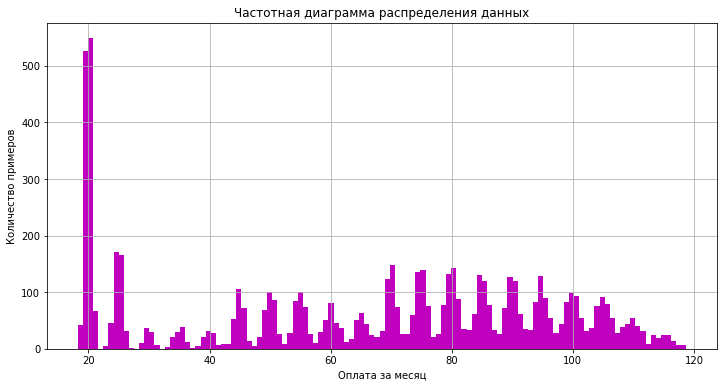

In [29]:
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(df['monthly_charges'], round(max(df['monthly_charges'])), color = 'm')
plt.xlabel('Оплата за месяц')
plt.ylabel('Количество примеров')
plt.title('Частотная диаграмма распределения данных')
plt.grid(True)
plt.show()

График распределения "monthly_charges" выглядит правдоподобно. Выброс вначале, вероятно, говорит о том, что большинство людей пользуются минимальным тарифом. 

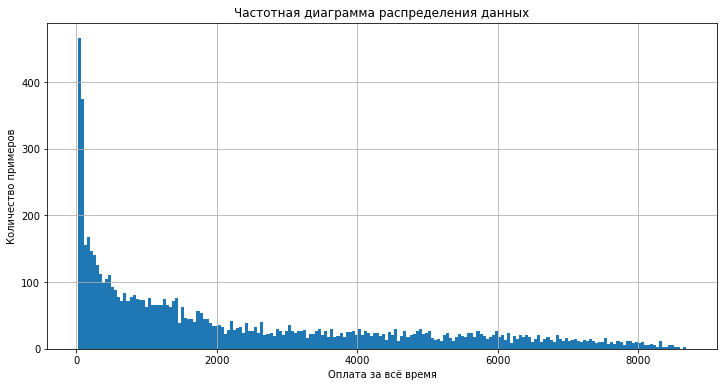

In [30]:
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(df['total_charges'], 200, color = 'tab:blue')
plt.xlabel('Оплата за всё время')
plt.ylabel('Количество примеров')
plt.title('Частотная диаграмма распределения данных')
plt.grid(True)
plt.show()

Выброс в начале и длинный хвост не дают разглядеть распределение. Приблизим.

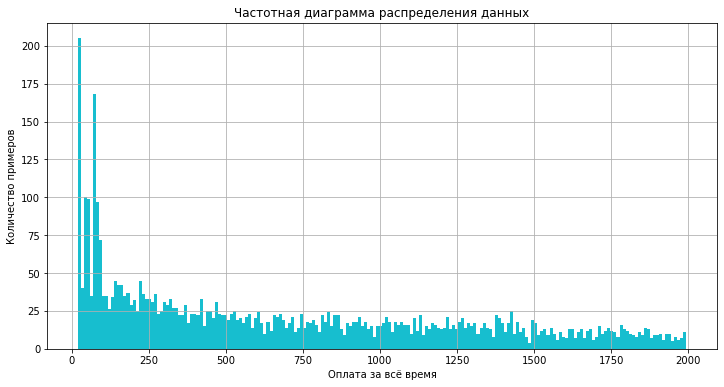

In [31]:
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(df[df['total_charges'] < 2000]['total_charges'], 200, color = 'tab:cyan')
plt.ylabel('Количество примеров')
plt.xlabel('Оплата за всё время')
plt.title('Частотная диаграмма распределения данных')
plt.grid(True)
plt.show()

График был бы похож на распределение Пуассона,если бы не выброс в районе минимума. Судя по всему, эти клиенты недавно заключили договоры.

Это можно посмотреть.

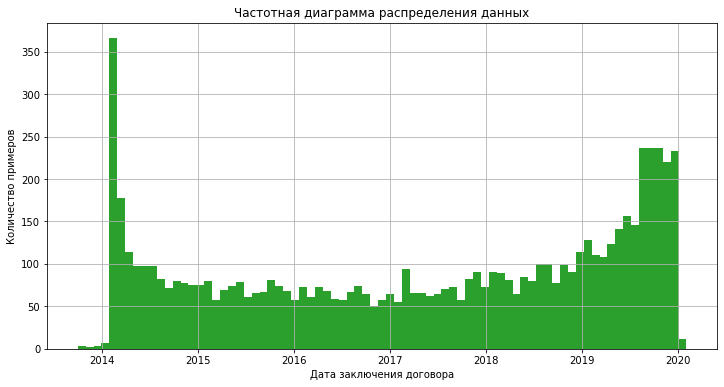

In [32]:
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(df['begin_date'], df['begin_date'].nunique(), color = 'tab:green' )
plt.ylabel('Количество примеров')
plt.xlabel('Дата заключения договора')
plt.title('Частотная диаграмма распределения данных')
plt.grid(True)
plt.show()

Интересно, что есть большой выброс в начале 2014 года. Возможно, это время начала работы компании и результат какой-то рекламной акции на старте, либо это время, когда перезаключались старые договора, если компания начала деятельность раньше.

В остальном график выглядит правдоподобно: резкий рост в начале, затем равномерное увеличение количества клиентов и в последние годы рост количества клиентов ускоряется.

#### Анализ категориальных данных

Посмотрим на графиках, как распределены данные в столбцах "type", "payment_method", "internet_service".

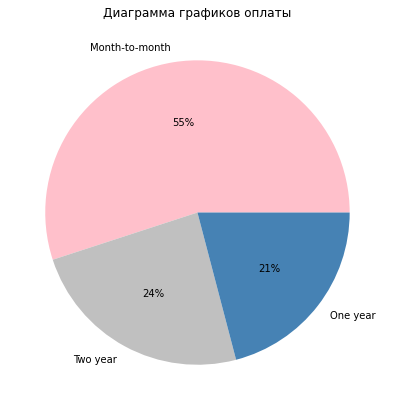

In [33]:
plt.figure(figsize=(7, 7))
plt.pie(list(df['type'].value_counts()), 
          labels=list(df['type'].value_counts().index), autopct='%.0f%%', 
          colors = ['pink', 'silver', 'steelblue'])
plt.title('Диаграмма графиков оплаты')
plt.show()

Больше половины клиентов предпочитают помесячную оплату.

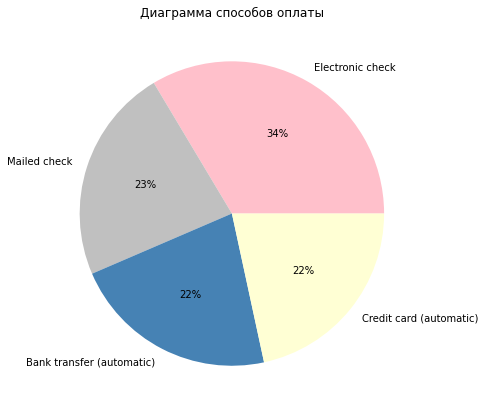

In [34]:
plt.figure(figsize=(7, 7))
plt.pie(list(df['payment_method'].value_counts()), 
          labels=list(df['payment_method'].value_counts().index), autopct='%.0f%%', 
          colors = ['pink', 'silver', 'steelblue', 'xkcd:eggshell'])
plt.title('Диаграмма способов оплаты')
plt.show()

Способы оплаты распределены почти равномерно, но электронные чеки популярнее других.

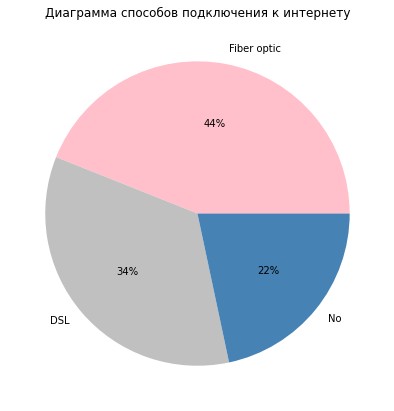

In [35]:
plt.figure(figsize=(7, 7))
plt.pie(list(df['internet_service'].value_counts()), 
          labels=list(df['internet_service'].value_counts().index), autopct='%.0f%%', 
          colors = ['pink', 'silver', 'steelblue'])
plt.title('Диаграмма способов подключения к интернету')
plt.show()


Около 20% клиентов не пользуются интернетом. Среди пользователей интернета популярность DSL значительно превышает оптоволоконное подключение на 10%.

Сравним предпочтения ушедших и лояльных клиентов в способах оплаты:

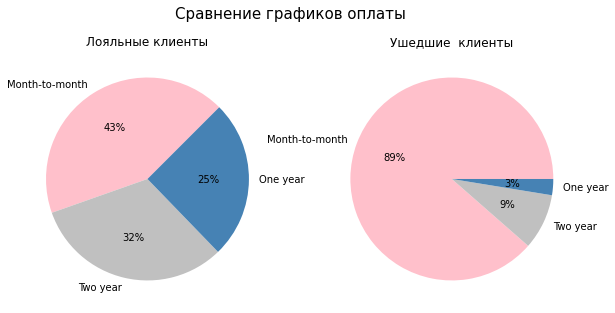

In [36]:
colors = ['pink', 'silver', 'steelblue']
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
fig.suptitle('Сравнение графиков оплаты', fontsize=15)
ax1.pie(list(df.loc[df['target']==0]['type'].value_counts()), 
        labels=list(df['type'].value_counts().index), autopct='%.0f%%', 
        colors = colors, startangle = 45)
ax1.set_title('Лояльные клиенты')
ax2.pie(list(df.loc[df['target']==1]['type'].value_counts()), 
        labels=list(df['type'].value_counts().index), autopct='%.0f%%', 
        colors = colors, startangle = 0)
ax2.set_title('Ушедшие  клиенты')
plt.show()

Явное отличие в графиках - ушедшие клиенты пользовались помесячным тарифом оплаты, редко годовым, и всего 2,6% ушедших платили за два года сразу.

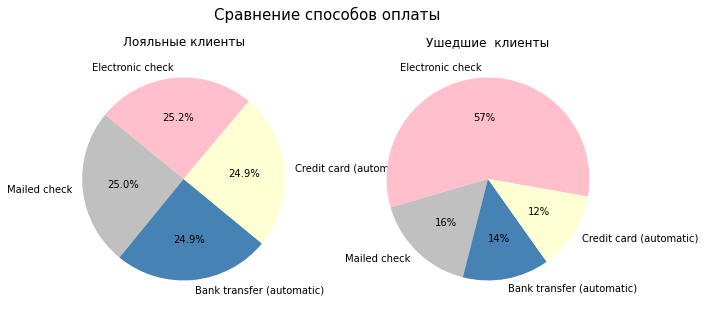

In [37]:
colors = ['pink', 'silver', 'steelblue', 'xkcd:eggshell']
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
fig.suptitle('Сравнение способов оплаты', fontsize=15)
ax1.pie(list(df.loc[df['target']==0]['payment_method'].value_counts()), 
        labels=list(df['payment_method'].value_counts().index), autopct='%.1f%%', 
        colors = colors, startangle = 50)
ax1.set_title('Лояльные клиенты')
ax2.pie(list(df.loc[df['target']==1]['payment_method'].value_counts()), 
        labels=list(df['payment_method'].value_counts().index), autopct='%.0f%%', 
        colors = colors, startangle = -10)
ax2.set_title('Ушедшие  клиенты')
plt.show()

Лояльные клиенты равномерно используют все четыре возможных способа оплаты.

Среди ушедших клиентов распределение неравномерное, они пользовались электронным чеком в 57% случаев, а автоматическое списание с кредитной карты выбирали только в 12% случаев.

Можно предположить, что клиенты просто не получали электронный чек, и с этим связан их уход. 

Есть смысл предложить клиентам, которых выявит модель, перейти в оплаты по электронным чекам на другой способ.

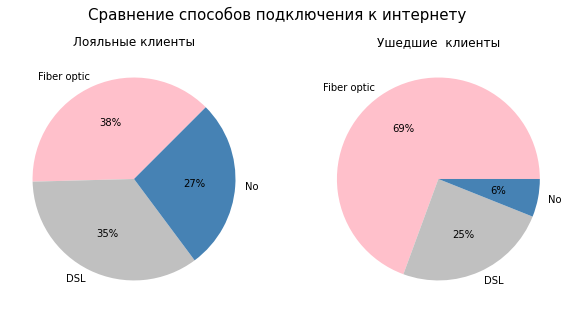

In [38]:
colors = ['pink', 'silver', 'steelblue']
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
fig.suptitle('Сравнение способов подключения к интернету', fontsize=15)
ax1.pie(list(df.loc[df['target']==0]['internet_service'].value_counts()), 
        labels=list(df['internet_service'].value_counts().index), autopct='%.0f%%', 
        colors = colors, startangle = 45)
ax1.set_title('Лояльные клиенты')
ax2.pie(list(df.loc[df['target']==1]['internet_service'].value_counts()), 
        labels=list(df['internet_service'].value_counts().index), autopct='%.0f%%', 
        colors = colors, startangle = 0)
ax2.set_title('Ушедшие  клиенты')
plt.show()

Ушедшие клиенты гораздо чаще лояльных пользовались технологией Fiber Optic. 

Есть смысл предложить потенциально уходящи клиентам, которых выявит модель, перейти на DSL.

## Уточняющие вопросы



1) В этом датафрейме нет целевого признака. Можно ли вывести его из столбца 'end_date' напрямую (если значение в столбце заполнено, это 1, если пустое - 0)?

2) Столбец с датой начала кажется неудобным для обучения моделей. Может быть, имеет смысл из него сделать новый - с количеством дней, когда человек пользовался услугами? Это будет понятный числовой признак.



## План решения задачи

1) Объединить датафреймы для удобства работы с данными, провести предобработку данных.

2) Сформировать целевой признак обучения.

3) Подготовить признаки к обучению модели. Разделить датафрейм на выборки.

4) Обучить несколько моделей классификации, выбрать наилучшую по ROC-AUC.

5) Проверить выбранную модель на тестовой выборке.


## Проверка мультиколлинеарности


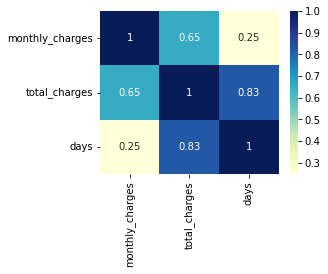

In [39]:
corr = df[['monthly_charges', 'total_charges','days']].corr()

plt.figure(figsize = (4, 3))

df_plot = sns.heatmap(corr, cmap="YlGnBu", annot=True)  

plt.show()

Колонка 'total_charges' имеет высокую степень корреляции 'days' и среднюю - с 'monthly_charges'. Если подумать логически, общая сумма оплаты и должна быть прямо пропорциональна ежемесячной сумма оплаты и продолжительности действия договора, являться их произведением в том случае клиент всё время пользовался одним и тем же тарифом и оплата за этот тариф не менялась. 

Столбец 'total_charges' кажется излишним, уберём его. 

In [40]:
df = df.drop('total_charges', axis = 1)
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender_male,senior_citizen,partner,dependents,multiple_lines,target,days
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,True,Electronic check,29.85,DSL,False,True,False,False,False,False,False,False,True,False,False,0,31
5575-GNVDE,2017-04-01,NaT,One year,False,Mailed check,56.95,DSL,True,False,True,False,False,False,True,False,False,False,False,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,53.85,DSL,True,True,False,False,False,False,True,False,False,False,False,1,61
7795-CFOCW,2016-05-01,NaT,One year,False,Bank transfer (automatic),42.30,DSL,True,False,True,True,False,False,True,False,False,False,False,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,70.70,Fiber optic,False,False,False,False,False,False,False,False,False,False,False,1,61


## Разделение на выборки

Разделим исходные данные на обучающую и тестовую выборки.
- Обучающая выборка - 75%
- Тестовая выборка - 25%

In [41]:
df_train, df_test = train_test_split(
    df, test_size=0.25, 
    random_state=RANDOM_STATE,
    stratify=df['target'])

print("Train/Test:", df_train.shape, df_test.shape)
print("Целевой признак:", round(df_train['target'].mean(), 4), ':', round(df_test['target'].mean(),4))

Train/Test: (5282, 20) (1761, 20)
Целевой признак: 0.2654 : 0.2652


## Подготовка признаков для обучения модели

Извлечём из датафрейма признаки. Столбцы с датами среди признаков не нужны.

In [42]:
target_train = df_train['target']
features_train = df_train.drop(['begin_date','end_date','target'], axis = 1)

target_test = df_test['target']
features_test = df_test.drop(['begin_date','end_date','target'], axis = 1)

Преобразуем категориальные признаки при помощи One-Hot Encoder, a числовые StandardScaler. Чтобы одновременно применить их на один набор признаков, используем  ColumnTransformer.

In [43]:
OHE = OneHotEncoder(drop = 'first')
scaler = StandardScaler()

cat_cols = ['type', 'payment_method', 'internet_service']
num_cols = ['monthly_charges', 'days']

transformer = ColumnTransformer([('cat_cols', OHE, cat_cols),
                                ('num_cols', scaler, num_cols)],
                                remainder='passthrough'
                               )

ohe_features_train = transformer.fit_transform(features_train)
ohe_features_test = transformer.transform(features_test)

features_train[num_cols] = scaler.fit_transform(features_train[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

In [44]:
print(features_train.shape, ohe_features_train.shape)

(5282, 17) (5282, 21)


## Выбор модели

### Модель Логистическая регрессия

Подбор гиперпараметров:

In [45]:
LogReg = LogisticRegression(max_iter = 1000, random_state = RANDOM_STATE)
params = {'C':[1,5, 10, 20, 30, 40, 50],
          'penalty': ['l1', 'l2'],
          'solver':['liblinear', 'saga']}
gridlog = GridSearchCV(LogReg, params, cv=3, scoring='roc_auc', refit = True)
gridlog.fit(ohe_features_train, target_train)
print('Наилучшие гиперпараметры: ', gridlog.best_params_)
print("ROC_AUC наилучшей модели:", round(gridlog.best_score_, 4))

Наилучшие гиперпараметры:  {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
ROC_AUC наилучшей модели: 0.8396


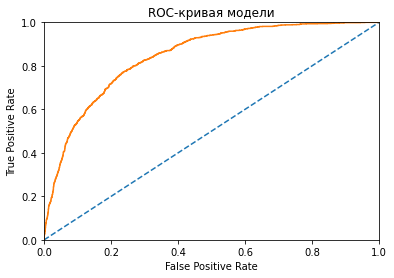

In [46]:
LogReg = gridlog.best_estimator_

fpr, tpr, thresholds = roc_curve(
    target_train, 
    LogReg.predict_proba(ohe_features_train)[:, 1]) 

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели')
plt.show() 

### Модель Ridge Classifier

In [47]:
RidClf = RidgeClassifier(max_iter = 1000, random_state = RANDOM_STATE)
params = {'alpha': range(1, 20)}
gridridge = GridSearchCV(RidClf, params, cv=5, scoring='roc_auc', refit = True)
gridridge.fit(ohe_features_train, target_train)
print('Наилучшие гиперпараметры: ', gridridge.best_params_)
print("ROC_AUC наилучшей модели:", round(gridridge.best_score_, 4))

Наилучшие гиперпараметры:  {'alpha': 14}
ROC_AUC наилучшей модели: 0.8375


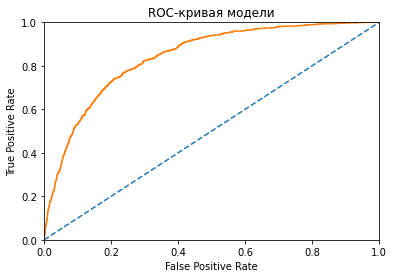

In [48]:
RidClf = gridridge.best_estimator_ 
fpr, tpr, thresholds = roc_curve(
    target_train, 
    RidClf.decision_function(ohe_features_train)) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели')
plt.show()

### Модель Decision Tree

Подбор оптимальной глубины дерева кросс-валидацией:

In [49]:
Tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
parametrs = { 'max_depth' : range (1, 13, 1)}
grid_Tree = GridSearchCV(Tree, parametrs, cv=3, scoring = 'roc_auc')
grid_Tree.fit(ohe_features_train, target_train)
best_parametrs = grid_Tree.best_params_
print('Наилучшее количество деревьев', best_parametrs)
print("ROC_AUC наилучшей модели:", round(grid_Tree.best_score_, 4))

Наилучшее количество деревьев {'max_depth': 6}
ROC_AUC наилучшей модели: 0.8478


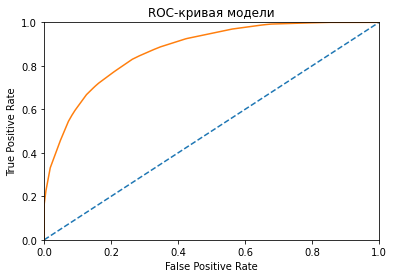

In [50]:
Tree = grid_Tree.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    Tree.predict_proba(ohe_features_train)[:, 1]) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели')
plt.show() 

### Модель Random Forest

Подбор гиперпараметров при помощи GridSearch:

In [51]:
%%time
Forest = RandomForestClassifier(random_state=RANDOM_STATE)
parametrs = { 'n_estimators'    : range (5, 20, 2),
              'max_depth'       : range (1, 13, 2),
              'min_samples_leaf': range (1,10)}
grid_Forest = GridSearchCV(Forest, parametrs, cv=2, scoring = 'roc_auc', n_jobs = -1)
grid_Forest.fit(ohe_features_train, target_train)
best_parametrs = grid_Forest.best_params_
print('Наилучшие гиперпараметры:', best_parametrs)
print("ROC_AUC наилучшей модели:", round(grid_Forest.best_score_, 4))

Наилучшие гиперпараметры: {'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 17}
ROC_AUC наилучшей модели: 0.8526
Wall time: 33.7 s


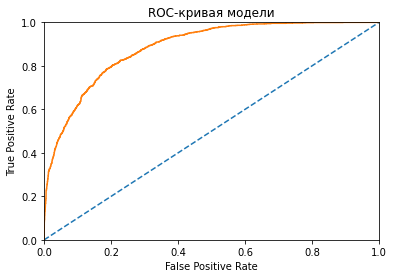

In [52]:
Forest = grid_Forest.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    Forest.predict_proba(ohe_features_train)[:, 1]) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели')
plt.show() 

### Модель CatBoostClassifier

Подбор гиперпараметров при помощи GridSearch:

In [53]:
cat_cols=['type', 'paperless_billing', 'payment_method',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender_male', 'senior_citizen', 'partner', 'dependents',
       'multiple_lines']

In [ ]:
%%time
CBC = CatBoostClassifier(random_seed  = RANDOM_STATE,
                        loss_function = 'Logloss',
                        custom_metric = 'PRAUC:type=Classic',
                        cat_features  = cat_cols,
                        #iterations    = 2000
                        )
parameters = {'depth'           : [2, 3],
              'learning_rate'   : [0.05, 0.1, 0.15],
              'l2_leaf_reg'     : [3, 64],
              'border_count'    : [75, 150],
              'iterations'      : [2000, 2500]
              }
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3, scoring = 'roc_auc', n_jobs = -1)
Grid_CBC.fit(features_train, target_train, plot = False, verbose = False)
print("Наилучшие гиперпараметры:",Grid_CBC.best_params_)
print("ROC_AUC наилучшей модели:", round(Grid_CBC.best_score_, 4))

In [ ]:
CBC = Grid_CBC.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    CBC.predict_proba(features_train)[:, 1]) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели')
plt.show() 

### Константная модель


Сравним работу  изученных моделей с константной моделью.

Работа константной модели. Она будет случайно предсказывать значение 0 и 1 с постоянной вероятностью, как в целевом признаке обучающей выборки.

In [ ]:
p = target_train.mean() # вероятнось единицы
predicted_train = np.where(p > np.random.rand(features_train.shape[0]), 1, 0, ) 
predicted_test = np.where(p > np.random.rand(features_test.shape[0]), 1, 0)
score_constant = roc_auc_score(target_train, predicted_train)
print(round(score_constant, 4))

### Сравнение моделей

Соберём результаты всех моделей:

In [ ]:
models_analysis = pd.DataFrame(
    data = [
    ['Logistic Regression', gridlog.best_score_],
    ['Ridge Classifier', gridridge.best_score_],
    ['Decision Tree', grid_Tree.best_score_],
    ['Random Forest', grid_Forest.best_score_],
    ['CatBoost', Grid_CBC.best_score_],
    ['Сonstant', score_constant]
],  columns = ['model', 'ROC_AUC']
).set_index('model').sort_values(by ='ROC_AUC')
models_analysis

In [ ]:
plt.figure(figsize = (7, 5))
plt.title('Сравнение ROC-AUC моделей')
plt.barh(y = models_analysis.index, 
         width = models_analysis['ROC_AUC']);

Все модели проходят проверку на адекватность, их ROC-AUC выше, чем у константной модели.



## Тестирование модели

Обучение наилучшей модели на обучающей выборке и проверка на тестовой.

In [ ]:
params = Grid_CBC.best_estimator_.get_params()
model = CatBoostClassifier(**params)
model.fit(features_train, target_train, plot = False, verbose = False)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
model_score = roc_auc_score(target_test, probabilities_one_test)
print('ROC-AUC модели на тестовой выборке', round(model_score, 4))
print('Параметры наилучшей модели:')
print(params)

Посмотрим матрицу ошибок:

Из всех 1761 записей предсказано, что:
   - 1 294 не планируют расторгнуть договор, и из них:
     - 1244 предсказаны верно,
     - 50 ошибок(клиент планирует уйти, но модель этого не предугадала);
   - 467 планируют расторгнуть договор, и из них:
     - 343 предсказаны верно;
     - 124 ошибок (модель предсказала уход лояльного клиента)

Вычисление метрик качества предсказания:

In [ ]:
print('Precision =', round(precision_score(target_test, prediction), 4))
print('Accuracy =', round(accuracy_score(target_test, prediction), 4))
print('F1-score =', round(f1_score(target_test, prediction), 4))

Точность достаточно высокая для решения поставленной перед моделью задачи.

Взглянем на ROC-кривую:

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, model.predict_proba(features_test)[:, 1]) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели CatBoost на тестовой выборке')
plt.show() 

Посмотрим на важность признаков по мнению модели:

In [ ]:
labels = df_train.drop(['begin_date','end_date','target'], axis = 1).columns

feature_importances = pd.DataFrame(
    zip(labels, model.feature_importances_), 
    columns = ['feature', 'importance']
    ).sort_values(by = 'importance', ascending = False)
    
plt.figure(figsize = (10, 10))
plt.title('Важность признаков')
feature_importances = feature_importances.sort_values(by = 'importance')
plt.barh(y = feature_importances.feature, 
         width = feature_importances['importance'])
plt.show;

Наиболее важными для предсказания оказались:
- время с заключения договора - с большим отрывом от остальных, 
- стоимость за месяц,
- платит ли клиент помесячно, за год или два,
- подключён ли клиент по оптоволокну или DSL.

## Вывод

Для оператора связи «Ниединогоразрыва.ком» подобрана модель машинного обучения, предсказывающая вероятность ухода клиента. При обучении модели для воспроизводимости результатов использовался фиксированный параметр  случайности, равный 171022.

Чтобы удержать клиента от перехода к конкуренту, «Ниединогоразрыва.ком» сможет предложить ему выгодные условия.

Метрики качества обучения модели на тестовой выборке:

|Метрика|Значение|
|------|------|
|ROC-AUC     |0.948     |
|Precision     |0.8728     |
|Accuracy | 0.9012|
|F1-score | 0.7977|


**Итоговая модель** имеет гиперпараметры:
-  'border_count': 150, 
-  'depth': 2, 
-  'iterations': 2500, 
-  'l2_leaf_reg': 3, 
-  'learning_rate': 0.15,
-  'random_seed' : 171022


Матрица ошибок:
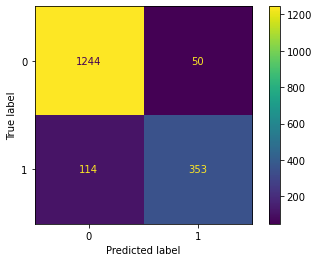

Из всех 100% тестовой выборки предсказано, что:
   - 73,5% не планируют расторгнуть договор, и:
     - 70,6% предсказаны верно,
     - 2,8% ошибок(клиент планирует уйти, но модель этого не предугадала);
   - 26,5% планируют расторгнуть договор, и из них:
     - 20% предсказаны верно;
     - 6,5% ошибок (модель предсказала уход лояльного клиента).

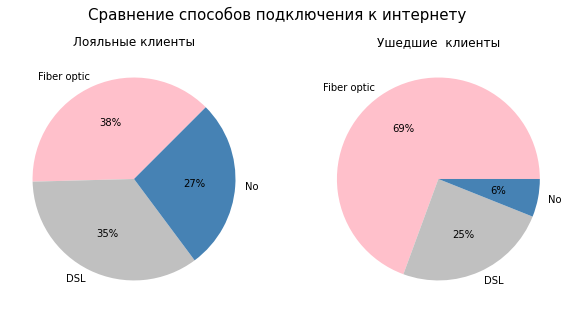


Ушедшие клиенты гораздо чаще лояльных пользовались технологией Fiber Optic. Есть смысл предложить потенциально уходящи клиентам, которых выявит модель, перейти на  DSL.
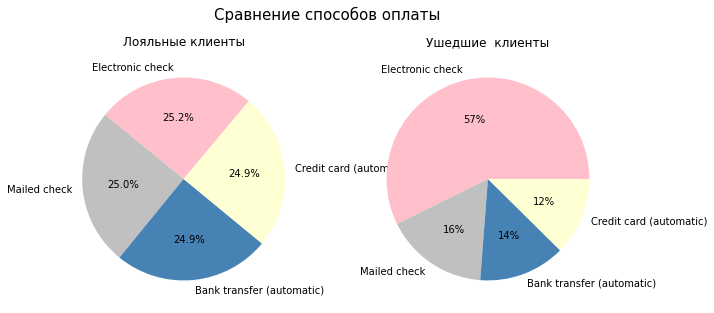
Среди ушедших клиентов распределение способов оплаты неравномерное, они пользовались электронным чеком в 57% случаев, а автоматическое списание с кредитной карты выбирали только в 12% случаев. Есть смысл предложить клиентам, которых выявит модель, перейти в оплаты по электронным чекам на другой способ.



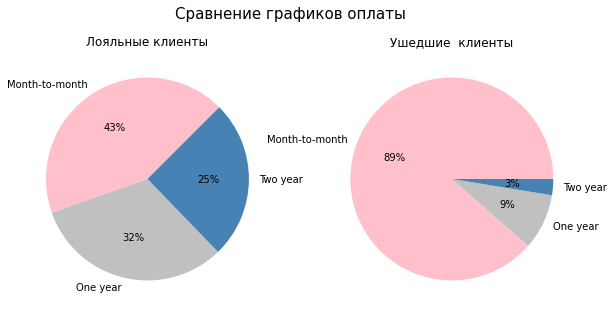
Ушедшие клиенты пользовались помесячным тарифом оплаты, редко годовым, и всего 3% ушедших платили за два года сразу. Клиентов, которых выявляет модель, можно стимулировать переходить на оплату за год или два. В обучении модели признак оплаты помесячно оказался на третьем месте по значимости предсказания.
     
Самый важный признак для предсказания - время с заключения договора.

### Отчёт 


##### Выполнены пункты плана:
1. Объединены датафреймы для удобства работы с данными, проведена предобработка данных
2. Сформирован целевой признак обучения    
3. Признаки подготовлены к обучению модели. Датафрейм разделён на тестовую и обучающую выборки  в соотношении 3:1  
4.Обучены модели классификации

    Результаты кросс-валидации: 

|Модель|ROC-AUC|
|------|------|
|Ridge Classifier	| 0.837453 |
|Logistic Regression |	0.839573 |
|Decision Tree |	0.847801 |
|Random Forest |	0.852637 |
|CatBoost |	0.927716 |

    Выбрана наилучшая по ROC-AUC модель - CatBoost Classifier
    
5. Модель проверена на тестовой выборке с результатом ROC-AUC = 0.948

При выполнении возникли трудности:
- с определением категориальных признаков, что привело к снижению скорости и качества обучения CatBoost модели. 
- были ошибочно включены в расчёт корреляции Пирсона категориальные (булевые) признаки. 
- расчёт ROC-AUC осуществлялся с ошибкой, что занижало получаемую ROC-AUC. После устранения ошибки расчётное значение ROC-AUC оказалось достаточным для завершения проекта. 

Ключевыми были шаги:
   - Предобработка признаков датафрейма,
   - Обучение нескольких моделей и выбор наилучшей,
   - Построение и оценка наилучшей модели предсказания.

**Итоговая модель** имеет гиперпараметры:
-  'border_count': 150, 
-  'depth': 2, 
-  'iterations': 2500, 
-  'l2_leaf_reg': 3, 
-  'learning_rate': 0.15,
-  'random_seed' : 171022

Метрики качества обучения модели на тестовой выборке:

|Метрика|Значение|
|------|------|
|ROC-AUC     |0.948     |
|Precision     |0.8728     |
|Accuracy | 0.9012|
|F1-score | 0.7977|


Матрица ошибок:
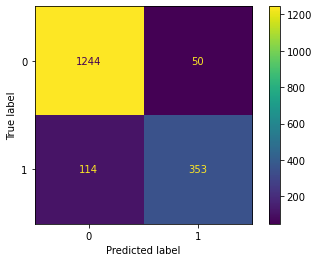

Из всех 100% тестовой выборки предсказано, что:
   - 73,5% не планируют расторгнуть договор, и:
     - 70,6% предсказаны верно,
     - 2,7% ошибок(клиент планирует уйти, но модель этого не предугадала);
   - 26,5% планируют расторгнуть договор, и из них:
     - 20% предсказаны верно;
     - 6,5% ошибок (модель предсказала уход лояльного клиента).